<a href="https://colab.research.google.com/github/kumudlakara/Shifts_evaluation_metrics_regression/blob/main/LENCE_and_R3_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: Initial part of the code including data preprocessing and basic uncertainty calculation is based on \\
https://github.com/yandex-research/shifts/tree/main/weather




In [ ]:
! git clone https://github.com/yandex-research/shifts

Cloning into 'shifts'...
remote: Enumerating objects: 2401, done.
remote: Counting objects: 100% (649/649), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 2401 (delta 435), reused 628 (delta 425), pack-reused 1752
Receiving objects: 100% (2401/2401), 10.52 MiB | 28.43 MiB/s, done.
Resolving deltas: 100% (1211/1211), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/shifts-main/weather/')

In [ ]:
#!tar -xvf "/content/drive/MyDrive/canonical-trn-dev-data.tar" -C "/content/drive/MyDrive/dataset/"     #[run this cell to extract tar files]

In [ ]:
import pandas as pd

# Load each data file as a pandas data frame
df_train = pd.read_csv('/content/drive/MyDrive/dataset/data/train.csv')
df_train.head()

,fact_time,fact_latitude,fact_longitude,fact_temperature,fact_cwsm_class,climate,topography_bathymetry,sun_elevation,climate_temperature,climate_pressure,cmc_0_0_0_1000,cmc_0_0_0_2_grad,cmc_0_0_0_2_interpolated,cmc_0_0_0_2_next,cmc_0_0_0_2,cmc_0_0_0_500,cmc_0_0_0_700,cmc_0_0_0_850,cmc_0_0_0_925,cmc_0_0_6_2,cmc_0_0_7_1000,cmc_0_0_7_2,cmc_0_0_7_500,cmc_0_0_7_700,cmc_0_0_7_850,cmc_0_0_7_925,cmc_0_1_0_0,cmc_0_1_11_0,cmc_0_1_65_0,cmc_0_1_66_0,cmc_0_1_67_0,cmc_0_1_68_0,cmc_0_1_7_0,cmc_0_2_2_10,cmc_0_2_2_1000,cmc_0_2_2_500,cmc_0_2_2_700,cmc_0_2_2_850,cmc_0_2_2_925,cmc_0_2_3_10,...,gfs_temperature_90000,gfs_temperature_92500,gfs_temperature_95000,gfs_temperature_97500,gfs_temperature_sea,gfs_temperature_sea_grad,gfs_temperature_sea_interpolated,gfs_temperature_sea_next,gfs_timedelta_s,gfs_total_clouds_cover_high,gfs_total_clouds_cover_low,gfs_total_clouds_cover_middle,gfs_u_wind,gfs_v_wind,gfs_wind_speed,wrf_available,wrf_t2,wrf_t2_next,wrf_psfc,wrf_rh2,wrf_wind_u,wrf_wind_v,wrf_rain,wrf_snow,wrf_graupel,wrf_hail,wrf_t2_interpolated,wrf_t2_grad,cmc_0_1_65_0_grad,cmc_0_1_65_0_next,cmc_0_1_66_0_grad,cmc_0_1_66_0_next,cmc_0_1_67_0_grad,cmc_0_1_67_0_next,cmc_0_1_68_0_grad,cmc_0_1_68_0_next,gfs_2m_dewpoint_grad,gfs_2m_dewpoint_next,gfs_total_clouds_cover_low_grad,gfs_total_clouds_cover_low_next
0,1.543321e+09,26.968800,-99.248901,2.0,0.0,dry,127.0,-17.526443,14.613571,754.263405,282.702881,6.684790,276.300439,282.985229,276.300439,262.333789,276.962134,280.083057,281.141064,272.500946,14.250,3.750,29.905515,15.500,29.750,15.750,0.0034,0.0,0.00000,0.0,0.0,0.0,0.00000,-1.327548,-2.914091,18.357608,8.480661,-1.510544,-0.465033,-0.126199,...,7.345331,7.926080,8.841516,9.350854,9.077112,1.966156,9.077112,11.043268,0.0,0.0,0.0,0.0,-2.328149,0.509014,2.383144,1.0,280.888000,280.420593,100927.414062,0.623658,-2.533346,-3.091468,0.0,0.0,0.0,0.0,280.888000,-0.467407,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-2.600006,-2.750006,0.0,0.0
1,1.538776e+09,29.374201,-100.927002,31.0,20.0,mild temperate,297.0,41.531032,26.992143,733.117168,305.860669,-1.361548,303.629541,302.267993,303.629541,267.178882,286.211719,291.642969,298.615479,293.701019,11.500,9.875,22.468424,26.500,1.375,6.250,0.0172,0.0,5.67340,0.0,0.0,0.0,0.00000,-3.568011,-3.632005,4.370947,0.653320,-3.227249,-4.499048,7.287793,...,24.699792,27.050012,29.526605,31.950006,32.831812,-2.257446,32.831812,30.574365,0.0,0.0,23.0,0.0,-3.851841,7.031523,8.017418,1.0,302.893005,303.356781,97645.507812,0.651412,-3.482976,5.238701,0.0,0.0,0.0,0.0,302.893005,0.463776,0.000000,5.673400,0.0,0.0,0.0,0.0,0.0,0.0,-0.600006,17.950006,-12.0,11.0
2,1.552115e+09,22.149599,113.592003,17.0,10.0,mild temperate,-1.0,43.916531,18.842143,761.571076,294.469702,0.282837,295.153361,295.341919,295.059082,268.584375,280.319653,288.922583,292.259375,293.914505,0.750,1.000,25.403430,1.625,2.375,0.125,0.0161,0.0,82.66500,0.0,0.0,0.0,0.00003,0.674461,0.812148,28.046518,20.135425,11.603281,5.047708,1.483844,...,17.325555,18.692010,20.252496,21.868280,23.101434,0.287476,23.197260,23.388910,3600.0,0.0,7.0,0.0,1.512065,4.074417,4.345942,1.0,295.782043,295.726929,100751.773438,0.989764,3.433286,5.181113,0.0,0.0,0.0,0.0,295.782043,-0.055115,0.771400,83.436400,0.0,0.0,0.0,0.0,0.0,0.0,-0.233978,21.450006,1.0,8.0
3,1.549566e+09,34.678699,-86.684799,24.0,20.0,mild temperate,193.0,40.240955,8.303571,747.524910,295.118774,1.091162,296.376611,297.467773,296.376611,262.566675,278.622852,285.923389,290.274927,288.752838,6.125,7.500,5.767445,14.000,4.875,4.125,0.0120,0.0,4.08775,0.0,0.0,0.0,0.00000,2.791129,2.760229,29.527142,25.678796,14.091809,6.503445,6.488293,...,12.791437,13.875513,15.751978,17.743524,19.321313,2.133026,19.321313,21.454340,0.0,21.0,99.0,0.0,2.277510,7.151445,7.505346,1.0,295.235687,296.000824,99450.273438,0.749565,-0.158933,8.494842,0.0,0.0,0.0,0.0,295.235687,0.765137,0.000000,4.087750,0.0,0.0,0.0,0.0,0.0,0.0,0.059448,16.150018,-58.0,41.0
4,1.552910e+09,46.066667,41.966667,9.0,20.0,dry,90.0,30.394660,6.451429,753.168113,28

In [ ]:
df_dev_in = pd.read_csv('/content/drive/MyDrive/dataset/data/dev_in.csv')
df_dev_out = pd.read_csv('/content/drive/MyDrive/dataset/data/dev_out.csv')

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def visualize_temperatures(df_list, df_names, plot_type='histogram'):
    '''
    Compare the distribution of temperature labels in datasets

    Supported visualization formats:
     - histogram
     - violin
    '''
    temperatures = np.concatenate([df['fact_temperature'] for df in df_list])
    names = np.concatenate([[name]*len(df) for name, df in zip(df_names, df_list)])

    df_to_plot = pd.DataFrame(data={'Temperature': temperatures, 'Dataset Name':names})

    if plot_type == 'histogram':
        sns.histplot(
            data=df_to_plot, x="Temperature", hue="Dataset Name",
            element="step", stat="density", common_norm=False)
    elif plot_type == 'violin':
        sns.violinplot(x='Temperature', y='Dataset Name',
                              data=df_to_plot, scale='width', palette='Set3')
    else:
        raise ValueError("Unsupported plot_type")
    
    plt.show()
    plt.clf()

In [ ]:
df_names = ['train', 'dev_in', 'dev_out']
df_list = [df_train, df_dev_in, df_dev_out]

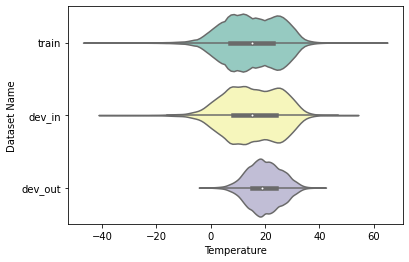

<Figure size 432x288 with 0 Axes>

In [ ]:
visualize_temperatures(df_list, df_names, plot_type='violin')

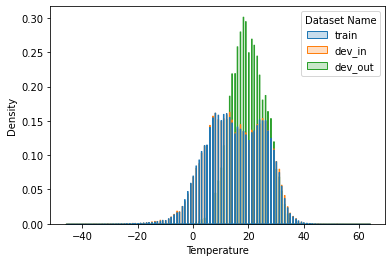

<Figure size 432x288 with 0 Axes>

In [ ]:
visualize_temperatures(df_list, df_names, plot_type='histogram')

In [ ]:
X_train = df_train.iloc[:,6:]
X_dev_in = df_dev_in.iloc[:,6:]
y_train = df_train['fact_temperature']
y_dev_in = df_dev_in['fact_temperature']

In [ ]:
ensemble_size = 3
depth = 2
iterations = 200
learning_rate = 0.03

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 22 kB/s 


In [ ]:
# Train ensemble of models

import catboost

trained_models = []
for seed in range(ensemble_size):
    
    model = catboost.CatBoostRegressor(
        learning_rate = learning_rate,
        iterations = iterations,
        depth = depth,
        loss_function = 'RMSEWithUncertainty',
        eval_metric = 'RMSE',
        random_seed = seed)
    
    print(f'\n Model index: {seed}\n')
    
    model.fit(
        X_train,
        y_train,
        verbose = 100,
        eval_set = (X_dev_in, y_dev_in))
    
    trained_models.append(model)

In [ ]:
dir_path = '/content/drive/MyDrive/saved-models'
for i, model in enumerate(trained_models):
    model.save_model(f'{dir_path}/model{i+1}.cbm')

In [ ]:
import catboost

In [ ]:
dir_path = '/content/drive/MyDrive/saved-models'
trained_models = []

# 3 models trained above in this tutorial
ensemble_size=10

for i in range(1, ensemble_size+1):
    model = catboost.CatBoostRegressor()
    model.load_model(f'{dir_path}/model{i}.cbm')
    trained_models.append(model)

In [ ]:
dir_path = '/content/drive/MyDrive/baseline/baseline-models'
baseline_models = []

# 10 models provided
ensemble_size=10

for ind in range(1, ensemble_size+1):
    model = catboost.CatBoostRegressor()
    model.load_model(f'{dir_path}/seed{ind}.cbm')
    baseline_models.append(model)


In [ ]:
# Create a combined evaluation dataset and keep only the features
df_dev = pd.concat([df_dev_in, df_dev_out])
X_dev = df_dev.iloc[:,6:]

In [ ]:
# Get ensemble of predictions for each data point

def get_predictions(features_df, model):
    '''
    Calculates predictions on df features for specified model
    
    Return: array [num_samples x 2],
        where
            num_samples = number of rows in features_df
            2 = [mean, variance]
    
    '''
    return model.predict(features_df)


def get_all_predictions(features_df, models_list):
    '''
    Return: array [ensemble_size x num_samples x 2],
        where
            ensemble_size = number of models in models_list
            num_samples = number of rows in features_df
            2 = [mean, variance]
    '''
    all_preds = []
    for model in models_list:
        preds = np.asarray(get_predictions(features_df, model))
        all_preds.append(preds)
    return np.stack(all_preds, axis=0)


all_preds = get_all_predictions(X_dev, baseline_models)

In [ ]:
def entropy_of_expected_class(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_examples, num_classes]
    :return: array [num_examples}
    """
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=1)


def expected_entropy_class(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_examples, num_classes]
    :return: array [num_examples}
    """
    log_probs = -np.log(probs + epsilon)

    return np.mean(np.sum(probs * log_probs, axis=2), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_examples, num_classes]
    :return: Dictionary of uncertaintties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=1)

    eoe = entropy_of_expected_class(probs, epsilon)
    exe = expected_entropy_class(probs, epsilon)

    mutual_info = eoe - exe

    epkl = -np.sum(mean_probs * mean_lprobs, axis=1) - exe

    uncertainty = {'confidence': conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'reverse_mutual_information': epkl - mutual_info
                   }

    return uncertainty


def epkl_reg(preds, epsilon=1e-10):
    """
    preds: array [n_models, n_samples, 2] - mean and var along last axis.
    """
    means = preds[:, :, 0]
    vars = preds[:, :, 1] + epsilon
    logvars = np.log(vars)

    avg_means = np.mean(means, axis=0)
    avg_second_moments = np.mean(means * means + vars, axis=0)

    inv_vars = 1.0 / vars
    avg_inv_vars = np.mean(inv_vars, axis=0)
    mean_inv_var = inv_vars * means
    avg_mean_inv_var = np.mean(mean_inv_var, axis=0)
    avg_mean2_inv_var = np.mean(means * mean_inv_var + logvars, axis=0) + np.log(2 * np.pi)

    epkl = 0.5 * (avg_second_moments * avg_inv_vars - 2 * avg_means * avg_mean_inv_var + avg_mean2_inv_var)

    return epkl



def ensemble_uncertainties_regression(preds, errors):
    """
    preds: array [n_models, n_samples, 2] - last dim is mean, var
    """
    epkl = epkl_reg(preds)
    var_mean = np.var(preds[:, :, 0], axis=0)
    mean_var = np.mean(preds[:, :, 1], axis=0)

    uncertainty = {'tvar': var_mean + mean_var,
                   'mvar': mean_var,
                   'varm': var_mean,
                   'epkl': epkl}

    return uncertainty

In [ ]:
# Get ensemble predictions
all_preds_mean = all_preds[:,:,0]
avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))#all_preds_mean 
# Get target values
targets = np.asarray(df_dev['fact_temperature'])

# squared error
errors = (avg_preds - targets) ** 2

In [ ]:
all_uncertainty = ensemble_uncertainties_regression(all_preds, errors)
uncertainties = all_uncertainty['tvar']

# ENCE and Covariance Coeff. Code

In [ ]:
all_preds_var = all_preds[:,:,1]
avg_preds_var = np.squeeze(np.mean(all_preds_var, axis=0))#all_preds_var 
print(avg_preds.shape, avg_preds_var.shape)
print(avg_preds_var.min())
print(avg_preds_var.max())
print(avg_preds_var[0])

(100000,) (100000,)
2.648777727001587e-09
3.0655090804407274e+41
0.5282458004702795


In [ ]:
def arrange(apv, ap, errs):
  idx = apv.argsort()
  apv = apv[idx]
  ap = ap[idx]
  errs = errs[idx]
  return apv, ap, errs

apv_arr,ap_arr, err_arr = arrange(avg_preds_var, avg_preds, errors)
print(avg_preds[0], ap_arr[0])
print(avg_preds_var[0], apv_arr[0])
print(err_arr.shape)

10.1094892208241 26.57552361141495
0.5282458004702795 2.648777727001587e-09
(100000,)


In [ ]:
def create_bins(ap_arr, apv_arr):
  N = 500           #number of bins
  bins = {}
  j = 200
  for i in range(0,N):
    idx = j*i
    bins[i+1] = {'mean':ap_arr[idx:idx+200], 'var':apv_arr[idx:idx+200]}
  return bins

bins = create_bins(ap_arr, apv_arr)
print(bins)

{1: {'mean': array([ 26.57552361,  27.57651282,  22.18088783,  11.87012835,
        19.67555455,  23.84788269,  13.38423833,  24.82584573,
        18.88153631,  18.26636117,  14.92803913,  19.27595525,
        22.28996737,  16.92279234,  13.94252071,  13.90157199,
        21.54707794,  15.51573685,  20.35347375,  19.81406087,
        24.78210188,  14.70173391,  23.67257501,  16.97604786,
        23.99132034,  15.81536272,  22.22349454,  23.84918512,
        26.33078767,  23.80908072,  22.04722763,  26.68869865,
        22.8181717 ,  21.91327733,  14.45860622,  25.93388821,
        20.24168626,  15.59910802,  22.80683239,  15.4410003 ,
        20.7475875 ,  16.05399307,  13.92141057,  20.89654457,
        22.9094138 ,  20.02342821,  19.46761963,  28.11551701,
         8.65936734,  14.41015085,  23.3544701 ,  25.39194981,
        15.24794668,  18.44015651,  18.64850702,  21.51005543,
        12.38547533,  14.14608473,  19.22706332,  15.06824415,
        13.70649843,  22.53924141,  17.380

In [ ]:
def root_mean_var(bins):
  rmv_list = []
  for i, mv_dict in bins.items():
    vars = mv_dict['var']
    rms = np.sqrt(np.sum(np.array(vars))/vars.shape[0])
    rmv_list.append(rms)
  return rmv_list

rmv_list = root_mean_var(bins)
print(rmv_list)

[0.10771254023994796, 0.2632985192442467, 0.31756001515410365, 0.3456229500316619, 0.36281956948738703, 0.37651366933450914, 0.3883873958775719, 0.39922561203407153, 0.4086084478047677, 0.41779807408685643, 0.4255242037394475, 0.4325296981495822, 0.4390482241213162, 0.4449044579617747, 0.45033804165831826, 0.45553915988742993, 0.46067680913416914, 0.46564840721490736, 0.4707475687561926, 0.4752562034428743, 0.48038397236456715, 0.48497555705275025, 0.48890509875144356, 0.4926198489577665, 0.4960243997764575, 0.49985209209348586, 0.5035790272404008, 0.5071807210219947, 0.5104631078781191, 0.513962225765394, 0.5172912762012849, 0.5205314632350274, 0.5237177174933436, 0.5267448043086114, 0.5295293263919912, 0.5327385082646303, 0.5358613253254259, 0.5387529233585931, 0.5415704322680635, 0.5442073930778745, 0.5470870156971843, 0.5497400568829758, 0.5523722823502034, 0.5551814681964693, 0.5576101452422214, 0.5600462757358222, 0.5626781859019439, 0.5652236488806285, 0.5678676300091234, 0.5701

In [ ]:
def root_mean_squared_error(bins, errs):
  rmse_list = []
  for i, mv_dict in bins.items():
    means = mv_dict['mean']
    idx = (i-1)*means.shape[0]
    rmse = np.sqrt(np.sum(errs[idx:idx+200])/means.shape[0])
    rmse_list.append(rmse)
  return rmse_list

rmse_list = root_mean_squared_error(bins, err_arr)
print(rmse_list)

[2.348964417740911, 1.6564804821294556, 1.3266902884436822, 1.3953053628587104, 1.523323120711374, 1.6360098522122104, 1.425982266028828, 1.4090884948585962, 1.5466651318594555, 1.5368934310603726, 1.4130661534361215, 1.6255865841099855, 1.9809926363496588, 1.79238114299078, 1.3044756244064741, 1.4392796395180034, 2.069944886648619, 1.2004841381415072, 1.5487432714679588, 1.482840495308268, 1.5681323923218364, 1.4230709454320065, 1.5042555341283839, 1.6246834399023908, 1.5384521184471573, 1.426061779950832, 1.7523925876444992, 1.358225668262347, 1.296422456390582, 1.4556711214256426, 1.6711323403832363, 1.3787638926000203, 1.4827289437674755, 1.627484366934792, 1.5275629176255883, 1.3741687769085529, 1.9945736394367815, 1.4619775349449724, 1.4964313224460852, 1.4675309388133693, 1.2433670878282663, 1.3986965703971994, 1.690900465577555, 1.4192928418491682, 1.4898178524609518, 1.4518067098787943, 1.5557557815984935, 1.5419246247714553, 1.735027028858603, 1.4558411624799639, 1.6243458209

In [ ]:
def get_ence(rmv_list, rmse_list):
  rmv_array = np.array(rmv_list)
  rmse_array = np.array(rmse_list)
  ence = (1/rmv_array.shape[0])*np.sum(((np.abs(rmv_array - rmse_array))/rmv_array))

  return ence

ence = get_ence(rmv_list, rmse_list)
print(ence)

1.0751141436777083


In [ ]:
def var_coeff_std(avg_preds_var):
  stds = np.sqrt(avg_preds_var)
  mu = (np.sum(stds))/avg_preds_var.shape[0]
  cv = (np.sqrt((np.sum((stds - mu)**2))/(avg_preds_var.shape[0] - 1)))/mu
  return cv


avg_preds_var = np.delete(avg_preds_var, np.where(avg_preds_var > 10))
cv = var_coeff_std(avg_preds_var)
print(cv)

0.3871797497680583


In [ ]:
def lence(ence, cv):
  return (np.log(ence + cv*(1 - cv)))

print(lence(ence, cv))

0.27184665250543566


# **R3 Curve**

# Ensemble

In [ ]:
def root_mean_squared_error(errs):
  rmse = np.sqrt(np.sum(errs)/errs.shape[0])
  return rmse

def root_mean_var(vars):
  rmv = np.sqrt(np.sum(vars)/vars.shape[0])
  return rmv

In [ ]:
#retention fraction
N = 100000
frac_list = []
def arrange(apv, ap, errs):
  idx = apv.argsort() #ascending order of variances
  apv = apv[idx]
  ap = ap[idx]
  errs = errs[idx]
  return apv, ap, errs

apv_arr,ap_arr, err_arr = arrange(avg_preds_var, avg_preds, errors)

retention_frac = [0.2, 0.4, 0.6, 0.8, 1.0]


for i in retention_frac:
  rmse = root_mean_squared_error(ap_arr[0:int(i*N)])
  rmv = root_mean_var(apv_arr[0:int(i*N)])
  frac = rmse/rmv
  #frac = rmv/rmse
  frac_list.append(frac)

In [ ]:
frac_list.insert(0,0.0)

In [ ]:
retention_frac.insert(0,0.0)

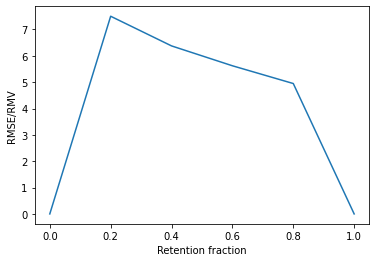

In [ ]:
plt.plot(retention_frac, frac_list)
plt.ylabel('RMSE/RMV')
plt.xlabel("Retention fraction")
plt.show()

In [ ]:
frac_list_ens = frac_list
ret_frac_list_ens = retention_frac

# Single model

In [ ]:
avg_preds = all_preds[0,:,0]
#avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))

# Get target values
targets = np.asarray(df_dev['fact_temperature'])

# squared error
errors = (avg_preds - targets) ** 2

In [ ]:
avg_preds_var = all_preds[0,:,1]
#avg_preds_var = np.squeeze(np.mean(all_preds_var, axis=0))
print(avg_preds.shape, avg_preds_var.shape)
print(avg_preds_var.min())
print(avg_preds_var.max())
print(avg_preds_var[0])

(100000,) (100000,)
1.5482729070319812e-16
1.1033528453839036e+37
1.963126860320886


In [ ]:
def root_mean_squared_error(errs):
  rmse = np.sqrt(np.sum(errs)/errs.shape[0])
  return rmse

def root_mean_var(vars):
  rmv = np.sqrt(np.sum(vars)/vars.shape[0])
  return rmv

In [ ]:
#retention fraction
N = 100000
frac_list = []
def arrange(apv, ap, errs):
  idx = apv.argsort() #ascending order of variances
  apv = apv[idx]
  ap = ap[idx]
  errs = errs[idx]
  return apv, ap, errs

apv_arr,ap_arr, err_arr = arrange(avg_preds_var, avg_preds, errors)

retention_frac = [0.2, 0.4, 0.6, 0.8, 1.0]
for i in retention_frac:
  rmse = root_mean_squared_error(ap_arr[0:int(i*N)])
  rmv = root_mean_var(apv_arr[0:int(i*N)])
  frac = rmse/rmv
  frac_list.append(frac)

In [ ]:
frac_list.insert(0,0.0)

In [ ]:
retention_frac.insert(0,0.0)

In [ ]:
frac_single = frac_list
ret_frac_single = retention_frac

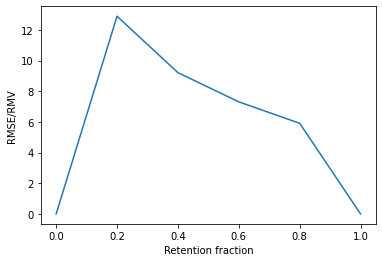

In [ ]:
plt.plot(retention_frac, frac_list)
plt.ylabel('RMSE/RMV')
plt.xlabel("Retention fraction")
plt.show()

## Combined R3 Plot

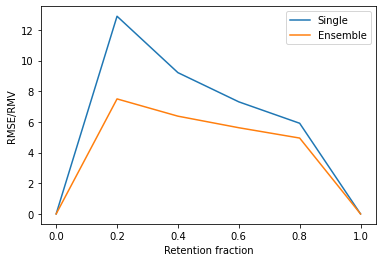

In [ ]:
plt.plot(ret_frac_single, frac_single)
plt.plot(ret_frac_list_ens, frac_list_ens)
plt.ylabel('RMSE/RMV')
plt.xlabel("Retention fraction")
plt.legend(['Single', 'Ensemble'])